# Setup
-  Follow the setup instructions based on your preferred environment!

## Local

One of our key goals in designing this assignment is to allow you to complete most of the preliminary implementation work locally.  
We highly recommend that you **pass all tests locally** using the provided `hw4_data_subset` before moving to a GPU runtime.  
To do this, simply:

### Create a new conda environment
```bash
# Be sure to deactivate any active environments first
conda create -n hw4 python=3.12.4
```

### Activate the conda environment
```bash
conda activate hw4
```

### Install the dependencies using the provided `requirements.txt`
```bash
pip install --no-cache-dir --ignore-installed -r requirements.txt
```

### Ensure that your notebook is in the same working directory as the `Handout`
This can be achieved by:
1. Physically moving the notebook into the handout directory.
2. Changing the notebook’s current working directory to the handout directory using the os.chdir() function.

### Open the notebook and select the newly created environment from the kernel selector.

If everything was done correctly, You should see atleast the following files in your current working directory after running `!ls`:
```
.
├── README.md
├── requirements.txt
├── hw4lib/
├── mytorch/
├── tests/
└── hw4_data_subset/
```

## Colab

### Step 1: Get your handout
- See writeup for recommended approaches.

### Step 2: Install Dependencies
- `NOTE`: Your runtime will be restarted to ensure all dependencies are updated.
- `NOTE`: You will see a runtime crashed message, this was intentionally done. Simply move on to the next cell.

# Imports

- If your setup was done correctly, you should be able to run the following cell without any issues.

In [16]:
from hw4lib.data import (
    H4Tokenizer,
    LMDataset,
    verify_dataloader
)
from hw4lib.model import (
    CausalMask,
    PadMask,
    PositionalEncoding,
    DecoderOnlyTransformer
)
from hw4lib.utils import (
    create_optimizer,
    create_scheduler,
    plot_lr_schedule
)
from hw4lib.trainers import (
    LMTrainer,
)
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import tarfile
import shutil
import wandb
import yaml
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# Implementations

- `NOTE`: All of these implementations have detailed specification, implementation details, and hints in their respective source files. Make sure to read all of them in their entirety to understand the implementation details!

## MyTorch Implementations
- Modify your `Linear` implementation from HW1P1 to support arbitrary number of dimensions in `mytorch/nn/linear.py`.
- Modify your `Softmax` implementation from HW1P1 to support arbitrary number of dimensions in `mytorch/nn/activation.py`.
- Implement the `ScaledDotProductAttention` class in `mytorch/nn/scaled_dot_product_attention.py`.
- Implement the `MultiHeadAttention` class in `mytorch/nn/multi_head_attention.py`.
- Run the cell below to check your implementations.


## Dataset Implementation
- Familiarize yourself with the `tokenize`, `encode`, and `decode` methods of the `H4Tokenizer` class in `hw4lib/data/tokenizer.py`. You will need to make use of these methods in both `HW4P1` and `HW4P2` both in the dataset implementations and during decoding.
- Implement the `LMDataset` class in `hw4lib/data/lm_dataset.py`.
    - You will have to implement parts of `__init__` and completely implement the `__len__`, `__getitem__` and `collate_fn` methods.
- Run the cell below to check your implementation.


In [17]:
!python -m tests.test_dataset_lm

Loading transcripts for train partition...
100%|███████████████████████████████████████| 267/267 [00:00<00:00, 8851.26it/s]

Running tests for category: LMDataset
--------------------------------------------------------------------------------

[01/01]    Running:  Test the LMDataset class
Testing __init__ method ...
Test Passed: Text files are sorted.
Test Passed: Shifted and golden transcripts are aligned.
Test Passed: All transcripts are decoded correctly after removing SOS and EOS tokens.
Testing __getitem__ method ...
Test Passed: SOS and EOS tokens are correctly placed for samples.
Test Passed: All transcripts are decoded correctly after removing SOS and EOS tokens.
Testing collate_fn method ...
Test Passed: Transcript batch has correct dimensions (2D tensor).
Test Passed: Transcript lengths are consistent with the batch size.
Test Passed: All sequences are padded to the same length.
Test Passed: Padding values are correct.
Test Passed: Batch transcripts are of correct data type.

In [18]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

## Tokenizer

In [19]:
Tokenizer = H4Tokenizer(
    token_map  = config['tokenization']['token_map'],
    token_type = config['tokenization']['token_type']
)

                          Tokenizer Configuration (5k)                          
--------------------------------------------------------------------------------
Vocabulary size:     5000

Special Tokens:
PAD:              0
UNK:              1
MASK:             2
SOS:              3
EOS:              4
BLANK:            5

Validation Example:
--------------------------------------------------------------------------------
Input text:  [SOS]HI DEEP LEARNERS[EOS]
Tokens:      ['[SOS]', 'H', 'I', 'ĠDEEP', 'ĠLEARN', 'ERS', '[EOS]']
Token IDs:   [3, 14, 15, 1169, 2545, 214, 4]
Decoded:     [SOS]HI DEEP LEARNERS[EOS]


## Datasets

In [20]:
train_dataset  = LMDataset(
    partition  = config['data']['train_partition'],
    config     = config['data'],
    tokenizer  = Tokenizer
)

val_dataset    = LMDataset(
    partition  = config['data']['val_partition'],
    config     = config['data'],
    tokenizer  = Tokenizer
)

test_dataset   = LMDataset(
    partition  = config['data']['test_partition'],
    config     = config['data'],
    tokenizer  = Tokenizer
)

gc.collect()

Loading transcripts for train partition...


100%|██████████| 267/267 [00:00<00:00, 8768.44it/s]


Loading transcripts for val partition...


100%|██████████| 7/7 [00:00<00:00, 5091.06it/s]


Loading transcripts for test partition...


100%|██████████| 7/7 [00:00<00:00, 5922.96it/s]


597082

## Dataloaders

In [21]:
train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = True,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn
)

val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
    collate_fn  = val_dataset.collate_fn
)

test_loader     = DataLoader(
    dataset     = test_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
    collate_fn  = test_dataset.collate_fn
)

### Dataloader Verification

## Calculate Max Transcript Length




Calculating the maximum transcript length across your dataset is a crucial step when working with certain transformer models.
-  We'll use sinusoidal positional encodings that must be precomputed up to a fixed maximum length.
- This maximum length is a hyperparameter that determines:
  - How long of a sequence your model can process
  - The size of your positional encoding matrix
  - Memory requirements during training and inference
- `Requirements`: For this assignment, ensure your positional encodings can accommodate at least the longest sequence in your dataset to prevent truncation. However, you can set this value higher if you anticipate using your language model to work with longer sequences in future tasks (hint: this might be useful for P2! 😉).

In [22]:
max_transcript_length = max(train_dataset.text_max_len, val_dataset.text_max_len, test_dataset.text_max_len)
print("="*50)
print(f"{'Global Max Transcript Length':<30} : {max_transcript_length}")
print("="*50)

Global Max Transcript Length   : 70


## Model

In [23]:
model_config = config['model']
model_config.update({
    'max_len': max_transcript_length,
    'num_classes': Tokenizer.vocab_size
})
model = DecoderOnlyTransformer(**model_config)

# Get some inputs from the text loader
for batch in train_loader:
    shifted_transcripts, golden_transcripts, transcript_lengths = batch
    print("Shape of shifted_transcripts : ", shifted_transcripts.shape)
    print("Shape of golden_transcripts  : ", golden_transcripts.shape)
    print("Shape of transcript_lengths  : ", transcript_lengths.shape)
    break

model_stats = summary(model, input_data=[shifted_transcripts, transcript_lengths])
print(model_stats)

Shape of shifted_transcripts :  torch.Size([128, 70])
Shape of golden_transcripts  :  torch.Size([128, 70])
Shape of transcript_lengths  :  torch.Size([128])
Layer (type:depth-idx)                        Output Shape              Param #
DecoderOnlyTransformer                        [128, 70, 5000]           --
├─Embedding: 1-1                              [128, 70, 512]            2,560,000
├─PositionalEncoding: 1-2                     [128, 70, 512]            --
├─Dropout: 1-3                                [128, 70, 512]            --
├─ModuleList: 1-4                             --                        --
│    └─SelfAttentionDecoderLayer: 2-1         [128, 70, 512]            1,024
│    │    └─SelfAttentionLayer: 3-1           [128, 70, 512]            1,051,648
│    │    └─FeedForwardLayer: 3-2             [128, 70, 512]            2,100,736
│    └─SelfAttentionDecoderLayer: 2-2         [128, 70, 512]            1,024
│    │    └─SelfAttentionLayer: 3-3           [128, 70, 512]

## Wandb

In [24]:
wandb.login(key="")

True

## Trainer

Every time you run the trainer, it will create a new directory in the `expts` folder with the following structure:
```
expts/
    └── {run_name}/
        ├── config.yaml
        ├── model_arch.txt
        ├── checkpoints/
        │   ├── checkpoint-best-metric-model.pth
        │   └── checkpoint-last-epoch-model.pth
        ├── attn/
        │   └── {attention visualizations}
        └── text/
            └── {generated text outputs}
```

In [25]:
trainer = LMTrainer(
    model=model,
    tokenizer=Tokenizer,
    config=config,
    run_name="test-lm",
    config_file="config.yaml",
    device=device
)

Using device: cuda


### Setup Optimizer and Scheduler

You can set your own optimizer and scheduler by setting the class members in the `LMTrainer` class.
Eg:
```python
trainer.optimizer = optim.AdamW(model.parameters(), lr=config['optimizer']['lr'], weight_decay=config['optimizer']['weight_decay'])
trainer.scheduler = optim.lr_scheduler.CosineAnnealingLR(trainer.optimizer, T_max=config['training']['epochs'])
```

We also provide a utility function to create your own optimizer and scheduler with the congig and some extra bells and whistles. You are free to use it or not. Do read their code and documentation to understand how it works (`hw4lib/utils/*`).


#### Setting up the optimizer

In [26]:
trainer.optimizer = create_optimizer(
    model=model,
    opt_config=config['optimizer']
)


🔧 Configuring Optimizer:
├── Type: ADAM
├── Base LR: 0.0003
├── Weight Decay: 0.0001
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── Adam Specific:
    ├── Betas: [0.9, 0.999]
    ├── Epsilon: 1e-08
    └── AMSGrad: False


#### Creating a test scheduler and plotting the learning rate schedule


📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 50 epochs (150 steps)
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (15 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


/home/agcheria/miniconda3/envs/hw4/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


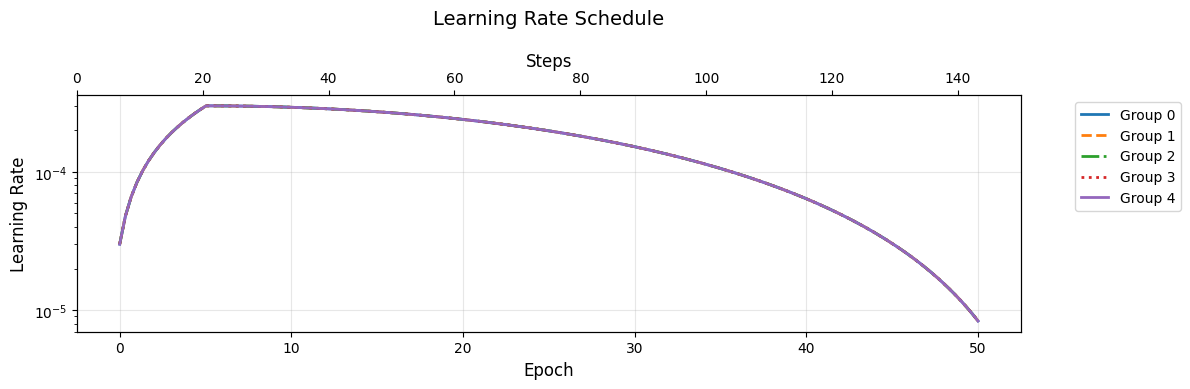

In [27]:
test_scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

plot_lr_schedule(
    scheduler=test_scheduler,
    num_epochs=config['training']['epochs'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

#### Setting up the scheduler

In [28]:
trainer.scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)


📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 50 epochs (150 steps)
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (15 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


# Train
- Set your epochs

In [29]:
trainer.train(train_loader, val_loader, epochs=config['training']['epochs'])

[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 0):
├── TRAIN:
│   ├── ce_loss_char: 2.0896
│   ├── ce_loss_token: 8.6461
│   ├── perplexity_char: 8.0813
│   └── perplexity_token: 5687.9697
└── VAL:
    ├── ce_loss_char: 2.1443
    ├── ce_loss_token: 8.4715
    ├── perplexity_char: 8.5359
    └── perplexity_token: 4776.8501
└── TRAINING:
    └── learning_rate: 0.000084


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 1):
├── TRAIN:
│   ├── ce_loss_char: 2.0238
│   ├── ce_loss_token: 8.3739
│   ├── perplexity_char: 7.5668
│   └── perplexity_token: 4332.4854
└── VAL:
    ├── ce_loss_char: 2.0558
    ├── ce_loss_token: 8.1219
    ├── perplexity_char: 7.8129
    └── perplexity_token: 3367.3762
└── TRAINING:
    └── learning_rate: 0.000138


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 2):
├── TRAIN:
│   ├── ce_loss_char: 1.9258
│   ├── ce_loss_token: 7.9687
│   ├── perplexity_char: 6.8608
│   └── perplexity_token: 2888.9666
└── VAL:
    ├── ce_loss_char: 1.9762
    ├── ce_loss_token: 7.8076
    ├── perplexity_char: 7.2155
    └── perplexity_token: 2459.2739
└── TRAINING:
    └── learning_rate: 0.000192


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 3):
├── TRAIN:
│   ├── ce_loss_char: 1.8387
│   ├── ce_loss_token: 7.6082
│   ├── perplexity_char: 6.2884
│   └── perplexity_token: 2014.5862
└── VAL:
    ├── ce_loss_char: 1.9075
    ├── ce_loss_token: 7.5362
    ├── perplexity_char: 6.7364
    └── perplexity_token: 1874.6454
└── TRAINING:
    └── learning_rate: 0.000246


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
[Training LM]:  33%|███▎      | 1/3 [00:00<00:00,  7.78it/s, acc_step=1/1, ce_loss_token=7.3181, perplexity_token=1507.3724]/home/agcheria/miniconda3/envs/hw4/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_W

Generating with greedy search...

📊 Metrics (Epoch 4):
├── TRAIN:
│   ├── ce_loss_char: 1.7669
│   ├── ce_loss_token: 7.3109
│   ├── perplexity_char: 5.8524
│   └── perplexity_token: 1496.4774
└── VAL:
    ├── ce_loss_char: 1.8462
    ├── ce_loss_token: 7.2940
    ├── perplexity_char: 6.3358
    └── perplexity_token: 1471.3903
└── TRAINING:
    └── learning_rate: 0.000300


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 5):
├── TRAIN:
│   ├── ce_loss_char: 1.7025
│   ├── ce_loss_token: 7.0447
│   ├── perplexity_char: 5.4879
│   └── perplexity_token: 1146.7944
└── VAL:
    ├── ce_loss_char: 1.7970
    ├── ce_loss_token: 7.0996
    ├── perplexity_char: 6.0317
    └── perplexity_token: 1211.5266
└── TRAINING:
    └── learning_rate: 0.000300


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 6):
├── TRAIN:
│   ├── ce_loss_char: 1.6496
│   ├── ce_loss_token: 6.8258
│   ├── perplexity_char: 5.2050
│   └── perplexity_token: 921.2969
└── VAL:
    ├── ce_loss_char: 1.7661
    ├── ce_loss_token: 6.9774
    ├── perplexity_char: 5.8479
    └── perplexity_token: 1072.0918
└── TRAINING:
    └── learning_rate: 0.000299


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 7):
├── TRAIN:
│   ├── ce_loss_char: 1.6135
│   ├── ce_loss_token: 6.6761
│   ├── perplexity_char: 5.0201
│   └── perplexity_token: 793.2386
└── VAL:
    ├── ce_loss_char: 1.7488
    ├── ce_loss_token: 6.9091
    ├── perplexity_char: 5.7476
    └── perplexity_token: 1001.3123
└── TRAINING:
    └── learning_rate: 0.000297


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 8):
├── TRAIN:
│   ├── ce_loss_char: 1.5888
│   ├── ce_loss_token: 6.5741
│   ├── perplexity_char: 4.8978
│   └── perplexity_token: 716.2662
└── VAL:
    ├── ce_loss_char: 1.7382
    ├── ce_loss_token: 6.8674
    ├── perplexity_char: 5.6873
    └── perplexity_token: 960.4406
└── TRAINING:
    └── learning_rate: 0.000295


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 9):
├── TRAIN:
│   ├── ce_loss_char: 1.5704
│   ├── ce_loss_token: 6.4981
│   ├── perplexity_char: 4.8088
│   └── perplexity_token: 663.8941
└── VAL:
    ├── ce_loss_char: 1.7313
    ├── ce_loss_token: 6.8398
    ├── perplexity_char: 5.6478
    └── perplexity_token: 934.3066
└── TRAINING:
    └── learning_rate: 0.000293


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 10):
├── TRAIN:
│   ├── ce_loss_char: 1.5538
│   ├── ce_loss_token: 6.4295
│   ├── perplexity_char: 4.7296
│   └── perplexity_token: 619.8386
└── VAL:
    ├── ce_loss_char: 1.7214
    ├── ce_loss_token: 6.8008
    ├── perplexity_char: 5.5923
    └── perplexity_token: 898.5743
└── TRAINING:
    └── learning_rate: 0.000289


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 11):
├── TRAIN:
│   ├── ce_loss_char: 1.5342
│   ├── ce_loss_token: 6.3482
│   ├── perplexity_char: 4.6377
│   └── perplexity_token: 571.4756
└── VAL:
    ├── ce_loss_char: 1.7078
    ├── ce_loss_token: 6.7473
    ├── perplexity_char: 5.5170
    └── perplexity_token: 851.7349
└── TRAINING:
    └── learning_rate: 0.000286


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 12):
├── TRAIN:
│   ├── ce_loss_char: 1.5110
│   ├── ce_loss_token: 6.2523
│   ├── perplexity_char: 4.5314
│   └── perplexity_token: 519.2206
└── VAL:
    ├── ce_loss_char: 1.7000
    ├── ce_loss_token: 6.7162
    ├── perplexity_char: 5.4739
    └── perplexity_token: 825.7109
└── TRAINING:
    └── learning_rate: 0.000281


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 13):
├── TRAIN:
│   ├── ce_loss_char: 1.4845
│   ├── ce_loss_token: 6.1427
│   ├── perplexity_char: 4.4129
│   └── perplexity_token: 465.2888
└── VAL:
    ├── ce_loss_char: 1.6902
    ├── ce_loss_token: 6.6775
    ├── perplexity_char: 5.4205
    └── perplexity_token: 794.3370
└── TRAINING:
    └── learning_rate: 0.000277


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 14):
├── TRAIN:
│   ├── ce_loss_char: 1.4574
│   ├── ce_loss_token: 6.0305
│   ├── perplexity_char: 4.2949
│   └── perplexity_token: 415.9192
└── VAL:
    ├── ce_loss_char: 1.6812
    ├── ce_loss_token: 6.6422
    ├── perplexity_char: 5.3722
    └── perplexity_token: 766.7728
└── TRAINING:
    └── learning_rate: 0.000271


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 15):
├── TRAIN:
│   ├── ce_loss_char: 1.4324
│   ├── ce_loss_token: 5.9270
│   ├── perplexity_char: 4.1887
│   └── perplexity_token: 375.0095
└── VAL:
    ├── ce_loss_char: 1.6763
    ├── ce_loss_token: 6.6225
    ├── perplexity_char: 5.3455
    └── perplexity_token: 751.8137
└── TRAINING:
    └── learning_rate: 0.000266


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 16):
├── TRAIN:
│   ├── ce_loss_char: 1.4085
│   ├── ce_loss_token: 5.8282
│   ├── perplexity_char: 4.0900
│   └── perplexity_token: 339.7587
└── VAL:
    ├── ce_loss_char: 1.6697
    ├── ce_loss_token: 6.5965
    ├── perplexity_char: 5.3104
    └── perplexity_token: 732.5062
└── TRAINING:
    └── learning_rate: 0.000259


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 17):
├── TRAIN:
│   ├── ce_loss_char: 1.3855
│   ├── ce_loss_token: 5.7328
│   ├── perplexity_char: 3.9967
│   └── perplexity_token: 308.8303
└── VAL:
    ├── ce_loss_char: 1.6638
    ├── ce_loss_token: 6.5732
    ├── perplexity_char: 5.2792
    └── perplexity_token: 715.6639
└── TRAINING:
    └── learning_rate: 0.000253


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 18):
├── TRAIN:
│   ├── ce_loss_char: 1.3626
│   ├── ce_loss_token: 5.6382
│   ├── perplexity_char: 3.9064
│   └── perplexity_token: 280.9691
└── VAL:
    ├── ce_loss_char: 1.6566
    ├── ce_loss_token: 6.5448
    ├── perplexity_char: 5.2413
    └── perplexity_token: 695.5902
└── TRAINING:
    └── learning_rate: 0.000246


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 19):
├── TRAIN:
│   ├── ce_loss_char: 1.3381
│   ├── ce_loss_token: 5.5368
│   ├── perplexity_char: 3.8118
│   └── perplexity_token: 253.8652
└── VAL:
    ├── ce_loss_char: 1.6504
    ├── ce_loss_token: 6.5205
    ├── perplexity_char: 5.2092
    └── perplexity_token: 678.9026
└── TRAINING:
    └── learning_rate: 0.000238


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 20):
├── TRAIN:
│   ├── ce_loss_char: 1.3148
│   ├── ce_loss_token: 5.4402
│   ├── perplexity_char: 3.7239
│   └── perplexity_token: 230.4885
└── VAL:
    ├── ce_loss_char: 1.6418
    ├── ce_loss_token: 6.4862
    ├── perplexity_char: 5.1642
    └── perplexity_token: 656.0215
└── TRAINING:
    └── learning_rate: 0.000230


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 21):
├── TRAIN:
│   ├── ce_loss_char: 1.2921
│   ├── ce_loss_token: 5.3463
│   ├── perplexity_char: 3.6403
│   └── perplexity_token: 209.8375
└── VAL:
    ├── ce_loss_char: 1.6320
    ├── ce_loss_token: 6.4475
    ├── perplexity_char: 5.1139
    └── perplexity_token: 631.1088
└── TRAINING:
    └── learning_rate: 0.000222


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 22):
├── TRAIN:
│   ├── ce_loss_char: 1.2682
│   ├── ce_loss_token: 5.2474
│   ├── perplexity_char: 3.5543
│   └── perplexity_token: 190.0674
└── VAL:
    ├── ce_loss_char: 1.6284
    ├── ce_loss_token: 6.4334
    ├── perplexity_char: 5.0957
    └── perplexity_token: 622.2853
└── TRAINING:
    └── learning_rate: 0.000214


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 23):
├── TRAIN:
│   ├── ce_loss_char: 1.2481
│   ├── ce_loss_token: 5.1642
│   ├── perplexity_char: 3.4836
│   └── perplexity_token: 174.9001
└── VAL:
    ├── ce_loss_char: 1.6303
    ├── ce_loss_token: 6.4410
    ├── perplexity_char: 5.1055
    └── perplexity_token: 627.0527
└── TRAINING:
    └── learning_rate: 0.000205


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 24):
├── TRAIN:
│   ├── ce_loss_char: 1.2302
│   ├── ce_loss_token: 5.0903
│   ├── perplexity_char: 3.4219
│   └── perplexity_token: 162.4348
└── VAL:
    ├── ce_loss_char: 1.6249
    ├── ce_loss_token: 6.4197
    ├── perplexity_char: 5.0781
    └── perplexity_token: 613.8486
└── TRAINING:
    └── learning_rate: 0.000196


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 25):
├── TRAIN:
│   ├── ce_loss_char: 1.2111
│   ├── ce_loss_token: 5.0113
│   ├── perplexity_char: 3.3572
│   └── perplexity_token: 150.0925
└── VAL:
    ├── ce_loss_char: 1.6290
    ├── ce_loss_token: 6.4357
    ├── perplexity_char: 5.0987
    └── perplexity_token: 623.7383
└── TRAINING:
    └── learning_rate: 0.000187


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 26):
├── TRAIN:
│   ├── ce_loss_char: 1.1931
│   ├── ce_loss_token: 4.9369
│   ├── perplexity_char: 3.2974
│   └── perplexity_token: 139.3325
└── VAL:
    ├── ce_loss_char: 1.6228
    ├── ce_loss_token: 6.4111
    ├── perplexity_char: 5.0670
    └── perplexity_token: 608.5859
└── TRAINING:
    └── learning_rate: 0.000178


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 27):
├── TRAIN:
│   ├── ce_loss_char: 1.1752
│   ├── ce_loss_token: 4.8626
│   ├── perplexity_char: 3.2387
│   └── perplexity_token: 129.3566
└── VAL:
    ├── ce_loss_char: 1.6223
    ├── ce_loss_token: 6.4094
    ├── perplexity_char: 5.0648
    └── perplexity_token: 607.5352
└── TRAINING:
    └── learning_rate: 0.000169


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 28):
├── TRAIN:
│   ├── ce_loss_char: 1.1584
│   ├── ce_loss_token: 4.7932
│   ├── perplexity_char: 3.1848
│   └── perplexity_token: 120.6826
└── VAL:
    ├── ce_loss_char: 1.6164
    ├── ce_loss_token: 6.3861
    ├── perplexity_char: 5.0350
    └── perplexity_token: 593.5196
└── TRAINING:
    └── learning_rate: 0.000159


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 29):
├── TRAIN:
│   ├── ce_loss_char: 1.1428
│   ├── ce_loss_token: 4.7288
│   ├── perplexity_char: 3.1356
│   └── perplexity_token: 113.1588
└── VAL:
    ├── ce_loss_char: 1.6181
    ├── ce_loss_token: 6.3926
    ├── perplexity_char: 5.0433
    └── perplexity_token: 597.4144
└── TRAINING:
    └── learning_rate: 0.000150


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 30):
├── TRAIN:
│   ├── ce_loss_char: 1.1290
│   ├── ce_loss_token: 4.6717
│   ├── perplexity_char: 3.0927
│   └── perplexity_token: 106.8761
└── VAL:
    ├── ce_loss_char: 1.6177
    ├── ce_loss_token: 6.3910
    ├── perplexity_char: 5.0413
    └── perplexity_token: 596.4765
└── TRAINING:
    └── learning_rate: 0.000141


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 31):
├── TRAIN:
│   ├── ce_loss_char: 1.1152
│   ├── ce_loss_token: 4.6144
│   ├── perplexity_char: 3.0501
│   └── perplexity_token: 100.9229
└── VAL:
    ├── ce_loss_char: 1.6185
    ├── ce_loss_token: 6.3942
    ├── perplexity_char: 5.0453
    └── perplexity_token: 598.3378
└── TRAINING:
    └── learning_rate: 0.000131


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 32):
├── TRAIN:
│   ├── ce_loss_char: 1.1034
│   ├── ce_loss_token: 4.5658
│   ├── perplexity_char: 3.0145
│   └── perplexity_token: 96.1395
└── VAL:
    ├── ce_loss_char: 1.6180
    ├── ce_loss_token: 6.3922
    ├── perplexity_char: 5.0428
    └── perplexity_token: 597.1550
└── TRAINING:
    └── learning_rate: 0.000122


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 33):
├── TRAIN:
│   ├── ce_loss_char: 1.0940
│   ├── ce_loss_token: 4.5266
│   ├── perplexity_char: 2.9861
│   └── perplexity_token: 92.4470
└── VAL:
    ├── ce_loss_char: 1.6174
    ├── ce_loss_token: 6.3899
    ├── perplexity_char: 5.0399
    └── perplexity_token: 595.8207
└── TRAINING:
    └── learning_rate: 0.000113


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 34):
├── TRAIN:
│   ├── ce_loss_char: 1.0836
│   ├── ce_loss_token: 4.4836
│   ├── perplexity_char: 2.9553
│   └── perplexity_token: 88.5561
└── VAL:
    ├── ce_loss_char: 1.6184
    ├── ce_loss_token: 6.3938
    ├── perplexity_char: 5.0449
    └── perplexity_token: 598.1333
└── TRAINING:
    └── learning_rate: 0.000104


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 35):
├── TRAIN:
│   ├── ce_loss_char: 1.0734
│   ├── ce_loss_token: 4.4414
│   ├── perplexity_char: 2.9252
│   └── perplexity_token: 84.8916
└── VAL:
    ├── ce_loss_char: 1.6195
    ├── ce_loss_token: 6.3981
    ├── perplexity_char: 5.0503
    └── perplexity_token: 600.7003
└── TRAINING:
    └── learning_rate: 0.000095


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 36):
├── TRAIN:
│   ├── ce_loss_char: 1.0652
│   ├── ce_loss_token: 4.4074
│   ├── perplexity_char: 2.9013
│   └── perplexity_token: 82.0555
└── VAL:
    ├── ce_loss_char: 1.6157
    ├── ce_loss_token: 6.3833
    ├── perplexity_char: 5.0315
    └── perplexity_token: 591.8940
└── TRAINING:
    └── learning_rate: 0.000086


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 37):
├── TRAIN:
│   ├── ce_loss_char: 1.0561
│   ├── ce_loss_token: 4.3700
│   ├── perplexity_char: 2.8752
│   └── perplexity_token: 79.0425
└── VAL:
    ├── ce_loss_char: 1.6123
    ├── ce_loss_token: 6.3698
    ├── perplexity_char: 5.0143
    └── perplexity_token: 583.9377
└── TRAINING:
    └── learning_rate: 0.000078


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 38):
├── TRAIN:
│   ├── ce_loss_char: 1.0497
│   ├── ce_loss_token: 4.3434
│   ├── perplexity_char: 2.8567
│   └── perplexity_token: 76.9652
└── VAL:
    ├── ce_loss_char: 1.6121
    ├── ce_loss_token: 6.3689
    ├── perplexity_char: 5.0132
    └── perplexity_token: 583.4178
└── TRAINING:
    └── learning_rate: 0.000070


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 39):
├── TRAIN:
│   ├── ce_loss_char: 1.0429
│   ├── ce_loss_token: 4.3155
│   ├── perplexity_char: 2.8375
│   └── perplexity_token: 74.8474
└── VAL:
    ├── ce_loss_char: 1.6141
    ├── ce_loss_token: 6.3769
    ├── perplexity_char: 5.0233
    └── perplexity_token: 588.0764
└── TRAINING:
    └── learning_rate: 0.000062


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 40):
├── TRAIN:
│   ├── ce_loss_char: 1.0376
│   ├── ce_loss_token: 4.2933
│   ├── perplexity_char: 2.8224
│   └── perplexity_token: 73.2050
└── VAL:
    ├── ce_loss_char: 1.6122
    ├── ce_loss_token: 6.3695
    ├── perplexity_char: 5.0139
    └── perplexity_token: 583.7660
└── TRAINING:
    └── learning_rate: 0.000054


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 41):
├── TRAIN:
│   ├── ce_loss_char: 1.0315
│   ├── ce_loss_token: 4.2679
│   ├── perplexity_char: 2.8051
│   └── perplexity_token: 71.3732
└── VAL:
    ├── ce_loss_char: 1.6099
    ├── ce_loss_token: 6.3605
    ├── perplexity_char: 5.0025
    └── perplexity_token: 578.5393
└── TRAINING:
    └── learning_rate: 0.000047


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 42):
├── TRAIN:
│   ├── ce_loss_char: 1.0259
│   ├── ce_loss_token: 4.2450
│   ├── perplexity_char: 2.7896
│   └── perplexity_token: 69.7553
└── VAL:
    ├── ce_loss_char: 1.6098
    ├── ce_loss_token: 6.3598
    ├── perplexity_char: 5.0016
    └── perplexity_token: 578.1193
└── TRAINING:
    └── learning_rate: 0.000041


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 43):
├── TRAIN:
│   ├── ce_loss_char: 1.0230
│   ├── ce_loss_token: 4.2331
│   ├── perplexity_char: 2.7816
│   └── perplexity_token: 68.9276
└── VAL:
    ├── ce_loss_char: 1.6104
    ├── ce_loss_token: 6.3625
    ├── perplexity_char: 5.0050
    └── perplexity_token: 579.6798
└── TRAINING:
    └── learning_rate: 0.000034


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 44):
├── TRAIN:
│   ├── ce_loss_char: 1.0209
│   ├── ce_loss_token: 4.2241
│   ├── perplexity_char: 2.7756
│   └── perplexity_token: 68.3129
└── VAL:
    ├── ce_loss_char: 1.6105
    ├── ce_loss_token: 6.3626
    ├── perplexity_char: 5.0052
    └── perplexity_token: 579.7652
└── TRAINING:
    └── learning_rate: 0.000029


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 45):
├── TRAIN:
│   ├── ce_loss_char: 1.0167
│   ├── ce_loss_token: 4.2070
│   ├── perplexity_char: 2.7641
│   └── perplexity_token: 67.1542
└── VAL:
    ├── ce_loss_char: 1.6105
    ├── ce_loss_token: 6.3627
    ├── perplexity_char: 5.0053
    └── perplexity_token: 579.8039
└── TRAINING:
    └── learning_rate: 0.000023


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 46):
├── TRAIN:
│   ├── ce_loss_char: 1.0139
│   ├── ce_loss_token: 4.1954
│   ├── perplexity_char: 2.7564
│   └── perplexity_token: 66.3827
└── VAL:
    ├── ce_loss_char: 1.6110
    ├── ce_loss_token: 6.3647
    ├── perplexity_char: 5.0078
    └── perplexity_token: 580.9613
└── TRAINING:
    └── learning_rate: 0.000019


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 47):
├── TRAIN:
│   ├── ce_loss_char: 1.0121
│   ├── ce_loss_token: 4.1878
│   ├── perplexity_char: 2.7513
│   └── perplexity_token: 65.8769
└── VAL:
    ├── ce_loss_char: 1.6114
    ├── ce_loss_token: 6.3664
    ├── perplexity_char: 5.0100
    └── perplexity_token: 581.9431
└── TRAINING:
    └── learning_rate: 0.000014


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 48):
├── TRAIN:
│   ├── ce_loss_char: 1.0110
│   ├── ce_loss_token: 4.1832
│   ├── perplexity_char: 2.7483
│   └── perplexity_token: 65.5730
└── VAL:
    ├── ce_loss_char: 1.6111
    ├── ce_loss_token: 6.3651
    ├── perplexity_char: 5.0083
    └── perplexity_token: 581.1929
└── TRAINING:
    └── learning_rate: 0.000011


[Training LM]:   0%|          | 0/3 [00:00<?, ?it/s]/home/agcheria/idl_assignment_Fall_2025/HW4/HW4P1/IDL-HW4/IDL-HW4/hw4lib/trainers/lm_trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Generating with greedy search...

📊 Metrics (Epoch 49):
├── TRAIN:
│   ├── ce_loss_char: 1.0090
│   ├── ce_loss_token: 4.1751
│   ├── perplexity_char: 2.7429
│   └── perplexity_token: 65.0448
└── VAL:
    ├── ce_loss_char: 1.6103
    ├── ce_loss_token: 6.3619
    ├── perplexity_char: 5.0043
    └── perplexity_token: 579.3645
└── TRAINING:
    └── learning_rate: 0.000007


# Evaluate


In [30]:
test_metrics, test_generation_results = trainer.evaluate(test_loader)
# Cleanup
trainer.cleanup()


📊 Metrics (Epoch 50):
└── TEST:
    ├── ce_loss_char: 1.7637
    ├── ce_loss_token: 6.5683
    ├── perplexity_char: 5.8343
    └── perplexity_token: 712.1301
└── TRAINING:
    └── learning_rate: 0.000007
Generating with greedy search...
Generating with greedy search...
Generating with greedy search...


wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

# Submission
To submit your assignment, you will need to create a `handin.tar` with the following directory structure:

```
handin/
├── mytorch/                     # Your implemented modules
├── test_metrics.json            # Results from evaluation
├── test_generated_results.json  # Sample text generations
└── model_arch.txt               # Model architecture summary
```

- Simply run the cell below once you are satisfied with your current state and this will create the `handin.tar` file.
- After running the above cell, you should see the handin.tar file in the current directory
- Upload the `handin.tar` file to the `HW4P1` assignment on Autolab.

In [ ]:
# Create temporary handin directory
if os.path.exists('handin'):
    shutil.rmtree('handin')
os.makedirs('handin')

# Copy mytorch directory
shutil.copytree('mytorch', 'handin/mytorch')

# Save final results
with open('handin/test_metrics.json', 'w') as f:
    json.dump(test_metrics, f, indent=4)

with open('handin/test_generated_results.json', 'w') as f:
    json.dump(test_generation_results['greedy'], f, indent=4)

# Save model architecture
with open('handin/model_arch.txt', 'w') as f:
    f.write(str(model_stats))

# Create tar file with all exclusions handled by filter
with tarfile.open('handin.tar', 'w') as tar:
    def filter_files(tarinfo):
        # Skip unwanted files
        if any(pattern in tarinfo.name for pattern in [
            '.DS_Store',
            '__pycache__',
            '.pyc'
        ]):
            return None
        return tarinfo

    tar.add('handin', arcname='handin', filter=filter_files)

# Cleanup
shutil.rmtree('handin')

print("Created handin.tar successfully!")

## After running the above cell, you should see the handin.tar file in the current directory
!ls